In [1]:
from Functions import get_processed_data
from sklearn.decomposition import PCA
from Functions import make_pca_agg_fit,add_pca_and_graph, prep_data_splits,size_clusters,anaylsis
import torch 
import os
from transfer_learning import MyDataset,NeuralNet_sherpa_optimize
import torch.nn as nn
import torch.optim as optim
from ignite.engine import Engine,Events
import time 
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from Functions import Transfer_graphs,preformance_graph_and_prep_2nd_set,create_std_matrix,unpack_dic,create_dictionaries

KeyboardInterrupt: 

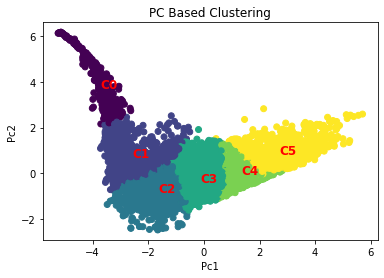

In [3]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,1,0,0,0,1]
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
s_M_Cluster=size_clusters(M_Cluster)
# parameters for neural net
epochs = 500
batch_size = 128
input_size = 5
output_size = 1
resolution=50
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
cluster=0
data = Cluster0
#checks for index problem
data = data.reset_index(drop=True)
#computer requirements 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()

features = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
#create splits 
df_train,df_val,df_test=prep_data_splits(data,features,interest)
#create dataset loader objects for looping through data,default test size is .2
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
#intialize holders for data
train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []

# initalize model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
learning_rate = trial_parameters["lr"]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#Create engine for running NN, pytorch

def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)
#sets up loss and R scores and stores values
#Note: note sure if can condense this into a module b/c of decorator and namespace

@trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    if loud[2]:
        print(e)
#Creates timer and runs trainer 
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)
plt.show()

if loud[3]:
    plt.plot(val_r_2)
    plt.plot(train_r_2,label="t")
    plt.plot(test_r_2,label="real")
    plt.legend()
    plt.show()
    plt.plot(val_loss)
    plt.plot(train_loss,label="t")
    plt.plot(test_loss,label="real")
    plt.legend()
    plt.show()
#save base model for transfer into other clusters in loop
torch.save(model, "Temp.ckpt")
#transfer learning part
#stores meta data
test_loss_holder=[]
test_r2_holder=[]
#loops through clusters
for count,i in enumerate(M_Cluster):
    train_loss = []
    train_r_2 = []
    val_loss = []
    val_r_2 = []
    test_loss = []
    test_r_2 = []
    net_time = []
    #loading model again
    model=torch.load("Temp.ckpt")
    descriptor_columns = [
        "void fraction",
        "Vol. S.A.",
        "Grav. S.A.",
        "Pore diameter Limiting",
        "Pore diameter Largest",
    ]
#turns off model learning
    model.fc1.weight.requires_grad = False
    model.fc1.bias.requires_grad = False
    model.fc2.weight.requires_grad = False
    model.fc2.bias.requires_grad = False

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
    )
    #Base Cluster for transfer learning 
    data = i
    #checks for index problem
    data = data.reset_index(drop=True)
    df_train,df_val,df_test=prep_data_splits(data,features,interest)
    #create dataset loader objects for looping through data,default test size is .2
    first = MyDataset(df_train, interest, features)
    train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

    second = MyDataset(df_val, interest, features)
    val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

    third = MyDataset(df_test, interest, features)
    test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

    #once again making training and testing engine
    def train_step_1(engine, batch):
        x, y = batch
        model.train()
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()

        return loss.item()


    transfer_trainer = Engine(train_step_1)
    n=int(epochs/resolution)
    @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
    def store_metrics(engine):
        end = time.time()
        e = engine.state.epoch
        out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
        out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
        out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
        out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
        out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
        out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
        train_loss.append(out)
        train_r_2.append(out1)
        val_loss.append(out2)
        val_r_2.append(out3)
        test_loss.append(out4)
        test_r_2.append(out5)
        net_time.append(end-start)
        if loud[4]:
            print(e)
    #runs model
    transfer_trainer.logger.disabled=True
    transfer_trainer.run(train_loader, max_epochs=epochs)
    test_loss_holder.append(test_loss)
    test_r2_holder.append(test_r_2)
#plots all clusers learning in terms of test set
if loud[5]:
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_loss_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()
    plt.show()
    plt.title(f"base {cluster}")
    for count,i in enumerate(test_r2_holder):
        plt.plot(i,label=f"Cluser {count}")
    plt.legend()

In [5]:
#if you want certain output and in order of array
    # controls graph pca and make pca
    # graph of pca cluster annotated
    # is the epoch count 
    # is graphs of first learning
    # transfer learning epochs
loud=[0,0,0,0,0,0]
#make clusters the same size with a random sample
resize=True
#make cluster run through
processed=get_processed_data()
#set variablility and number of clusters
var=.9
g_comp=6
#predicting (only supports 1 prediction as of now, but should work with more not tested)
interest = ["H2@100 bar/243K (wt%)"]
#make PCA to run )
#Make PCA on data and generate 
pc1,pc2,color=make_pca_agg_fit(1,processed,var,g_comp,array_out=True,loud=loud[0])
#get unprocessed data
data=get_processed_data(unprocessed=True)
pca_df=add_pca_and_graph(processed,pc1,pc2,color,graph=loud[1])
#puts in old data needed, but can't be processed in PCA
pca_df[['MOF ID',interest[0],'topology']]=data[['MOF ID',interest[0],'topology']]

#removes some unneeded columns
abridge=pca_df[['MOF ID', 'void fraction', 'Vol. S.A.', 'Grav. S.A.','Pore diameter Limiting', 'Pore diameter Largest',interest[0],'topology', 'Pc1', 'Pc2', 'Cluster']]

# generate Cluster data sets 
Cluster0=abridge[abridge["Cluster"]==0]
Cluster1=abridge[abridge["Cluster"]==1]
Cluster2=abridge[abridge["Cluster"]==2]
Cluster3=abridge[abridge["Cluster"]==3]
Cluster4=abridge[abridge["Cluster"]==4]
Cluster5=abridge[abridge["Cluster"]==5]
# generate holder for dataframes for looping 
O_M_Cluster=[Cluster0,Cluster1,Cluster2,Cluster3,Cluster4,Cluster5]
#
# parameters for neural net
epochs = 500
resolution=100
batch_size = 128
input_size = 5
output_size = 1
# specifc for neural net class
trial_parameters={
    "lr" : 0.005,
    "H_l1" : 250,
    "activate" :  "nn.PReLU"
}
#Base Cluster for transfer learning 
#specify cluster
meta_trials=100
meta=[]
for final,i in enumerate(range(meta_trials)):
    #create holder for meta anaylsis
    mega={}
    for i in range(len(M_Cluster)):
        mega[i]=[]
    if resize:
        M_Cluster=size_clusters(O_M_Cluster)
    for count,g in enumerate(M_Cluster):
        cluster=count
        data = g
        #checks for index problem
        data = data.reset_index(drop=True)
        #computer requirements 
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        base_path = os.getcwd()

        features = [
            "void fraction",
            "Vol. S.A.",
            "Grav. S.A.",
            "Pore diameter Limiting",
            "Pore diameter Largest",
        ]
        #create splits 
        df_train,df_val,df_test=prep_data_splits(data,features,interest)
        #create dataset loader objects for looping through data,default test size is .2
        first = MyDataset(df_train, interest, features)
        train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

        second = MyDataset(df_val, interest, features)
        val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

        third = MyDataset(df_test, interest, features)
        test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))
        #intialize holders for data
        train_loss = []
        train_r_2 = []
        val_loss = []
        val_r_2 = []
        test_loss = []
        test_r_2 = []
        net_time = []

        # initalize model
        model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
        criterion = nn.MSELoss()
        learning_rate = trial_parameters["lr"]
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        #Create engine for running NN, pytorch

        def train_step(engine, batch):
            x, y = batch
            model.train()
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()

            return loss.item()

        trainer = Engine(train_step)
        #sets up loss and R scores and stores values
        #Note: note sure if can condense this into a module b/c of decorator and namespace
        @trainer.on(Events.EPOCH_COMPLETED(every=50))
        def store_metrics(engine):
            end = time.time()
            e = engine.state.epoch
            out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
            out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
            out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
            out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
            out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
            out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
            train_loss.append(out)
            train_r_2.append(out1)
            val_loss.append(out2)
            val_r_2.append(out3)
            test_loss.append(out4)
            test_r_2.append(out5)
            net_time.append(end-start)
            if loud[2]:
                print(e)
        #Creates timer and runs trainer 
        start = time.time()
        trainer.logger.disabled=True
        trainer.run(train_loader, max_epochs=epochs)
        plt.show()

        if loud[3]:
            plt.plot(val_r_2)
            plt.plot(train_r_2,label="t")
            plt.plot(test_r_2,label="real")
            plt.legend()
            plt.show()
            plt.plot(val_loss)
            plt.plot(train_loss,label="t")
            plt.plot(test_loss,label="real")
            plt.legend()
            plt.show()
        #save base model for transfer into other clusters in loop
        torch.save(model, "Temp2.ckpt")
        #transfer learning part
        #stores meta data
        test_loss_holder=[]
        test_r2_holder=[]
        #loops through clusters
        for count,i in enumerate(M_Cluster):
            train_loss = []
            train_r_2 = []
            val_loss = []
            val_r_2 = []
            test_loss = []
            test_r_2 = []
            net_time = []
            #loading model again
            model=torch.load("Temp2.ckpt")
            descriptor_columns = [
                "void fraction",
                "Vol. S.A.",
                "Grav. S.A.",
                "Pore diameter Limiting",
                "Pore diameter Largest",
            ]
        #turns off model learning
            model.fc1.weight.requires_grad = False
            model.fc1.bias.requires_grad = False
            model.fc2.weight.requires_grad = False
            model.fc2.bias.requires_grad = False

            optimizer = optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
            )
            #Base Cluster for transfer learning 
            data = i
            #checks for index problem
            data = data.reset_index(drop=True)
            df_train,df_val,df_test=prep_data_splits(data,features,interest)
            #create dataset loader objects for looping through data,default test size is .2
            first = MyDataset(df_train, interest, features)
            train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

            second = MyDataset(df_val, interest, features)
            val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

            third = MyDataset(df_test, interest, features)
            test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

            #once again making training and testing engine
            def train_step_1(engine, batch):
                x, y = batch
                model.train()
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                return loss.item()


            transfer_trainer = Engine(train_step_1)
            n=int(epochs/resolution)
            @transfer_trainer.on(Events.EPOCH_COMPLETED(every=n))
            def store_metrics(engine):
                end = time.time()
                e = engine.state.epoch
                out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
                out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
                out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
                out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
                out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
                out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
                train_loss.append(out)
                train_r_2.append(out1)
                val_loss.append(out2)
                val_r_2.append(out3)
                test_loss.append(out4)
                test_r_2.append(out5)
                net_time.append(end-start)
                if loud[4]:
                    print(e)
            #runs model
            transfer_trainer.logger.disabled=True
            transfer_trainer.run(train_loader, max_epochs=epochs)
            test_loss_holder.append(test_loss)
            test_r2_holder.append(test_r_2)
        #because error tends to be low, only anaylizing r2 scores
            mega[count].append(test_r_2)
        #plots all clusers learning in terms of test set
        if loud[5]:
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_loss_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
            plt.show()
            plt.title(f"base {cluster}")
            for count,i in enumerate(test_r2_holder):
                plt.plot(i,label=f"Cluser {count}")
            plt.legend()
    meta.append(mega)
    print(final)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


KeyboardInterrupt: 

In [6]:
len(meta)

70

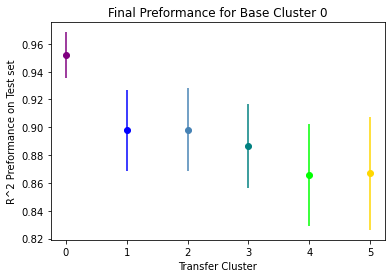

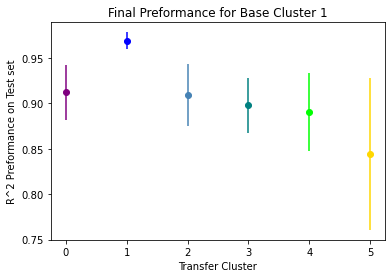

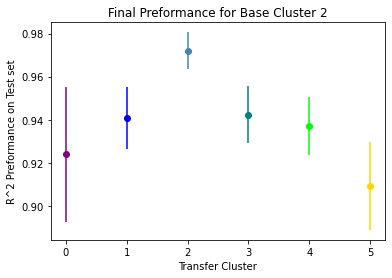

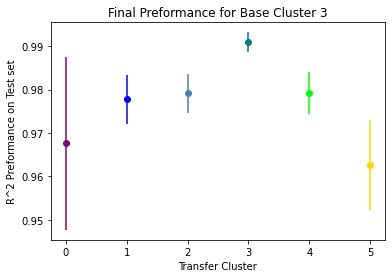

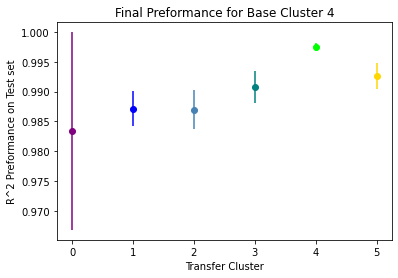

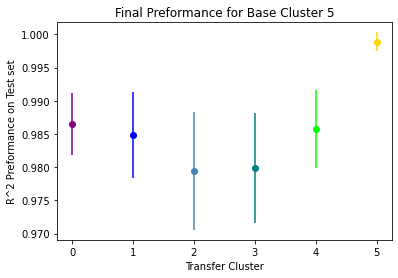

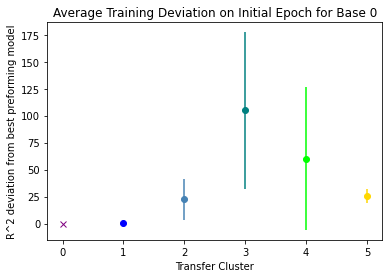

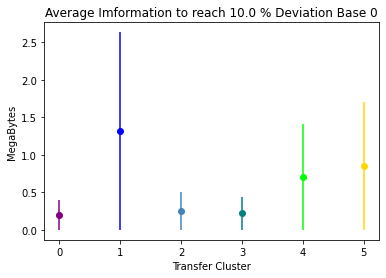

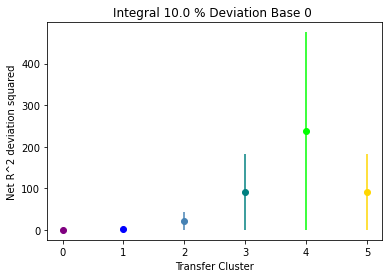

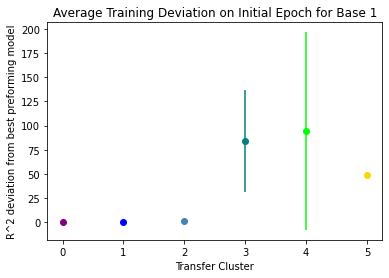

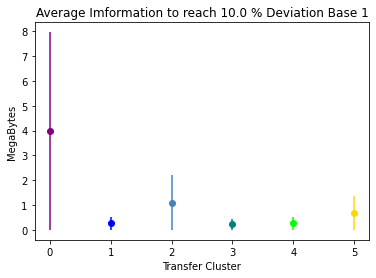

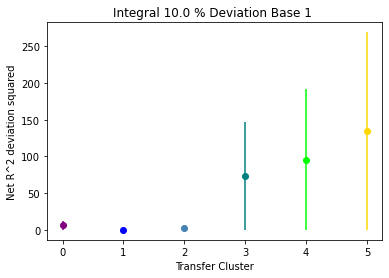

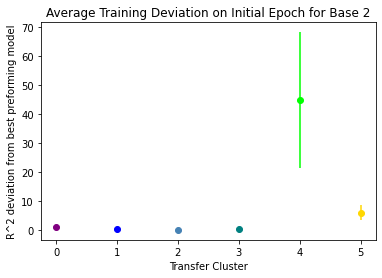

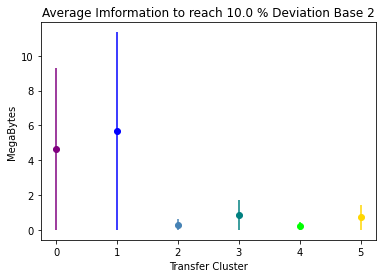

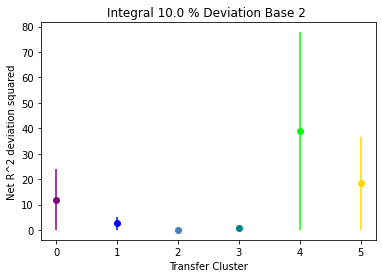

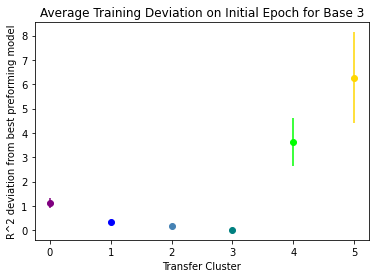

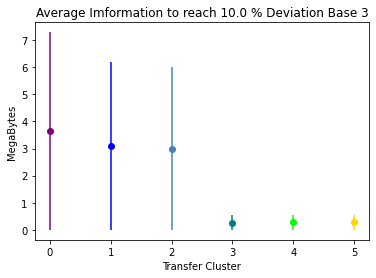

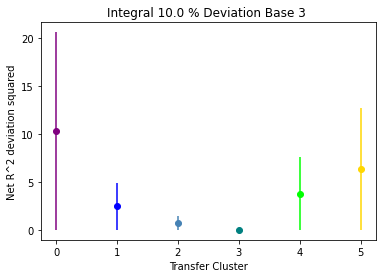

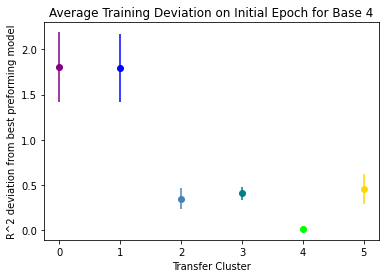

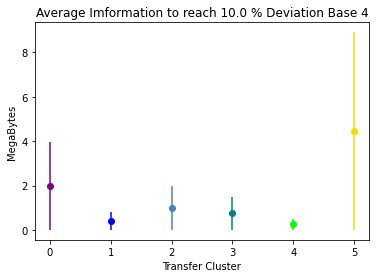

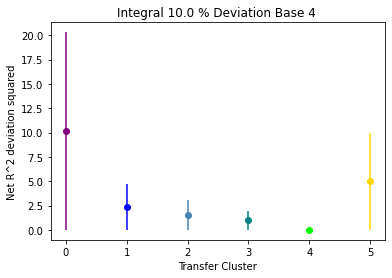

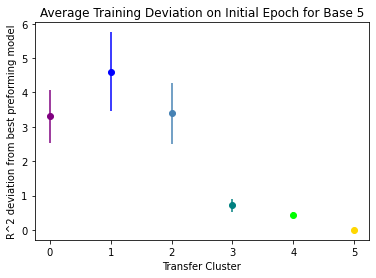

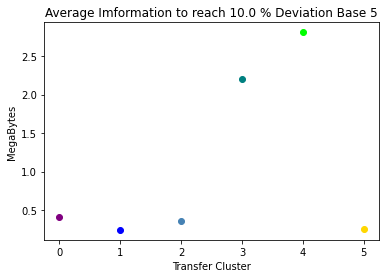

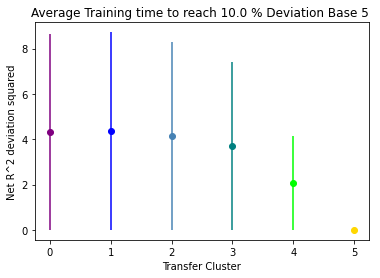

In [7]:
Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
dic,dic2,std=create_dictionaries(6)
dic=unpack_dic(dic,meta)
std=create_std_matrix(dic,std)

dic2=preformance_graph_and_prep_2nd_set(Cluster_colors,dic,dic2)
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))
Transfer_graphs(dic2,resolution,epoch_conversions,Cluster_colors,byte,std)

In [9]:
import itertools
indexer=itertools.product(range(6),range(6))
dic={}
for i in indexer:
    dic[i]=[]
indexer=itertools.product(range(6),range(6))
dic2={}
for i in indexer:
    dic2[i]=[]
std_store={}
for i in indexer:
    std_store[i]=[]

In [10]:
import numpy as np
for i in meta:
    for g in i:
        for count,z in enumerate(i[g]):
            dic[(g,count)].append(z)


In [11]:
for z in dic:
    matrix=np.matrix(dic[z][0])
    for count,i in enumerate(dic[z]):
        if count==0:
            pass
        else:
            i=np.matrix(i)
            matrix=np.concatenate([matrix,i],axis=0)
    matrix=np.matrix(matrix)
    std_store[z]=np.array(matrix.std(axis=0,dtype=float))[0]

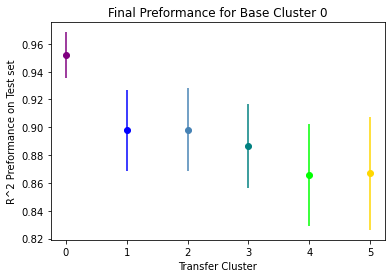

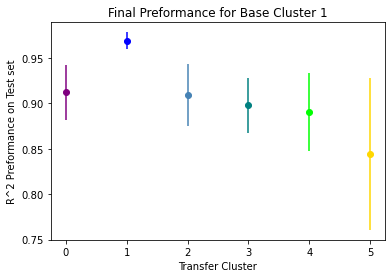

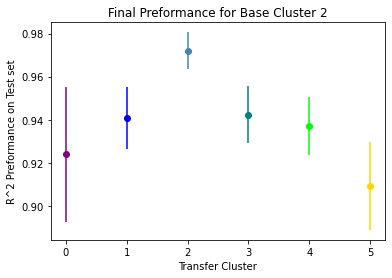

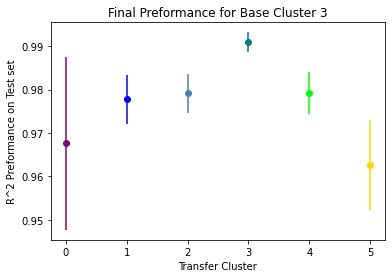

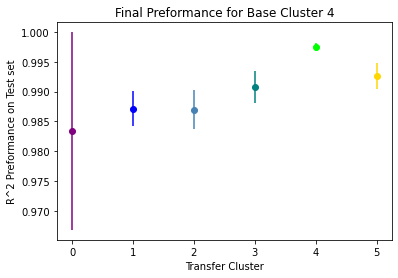

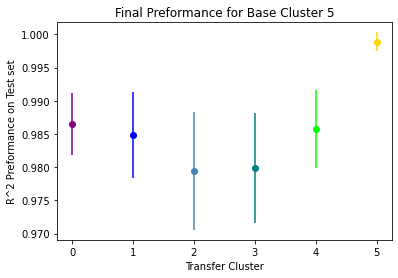

In [12]:
#Cluster_colors=["purple","b","steelblue","teal","lime","gold"]
last=0
adjust=53
Up_max=[]
for i in dic:
    f_index=i[0]
    if f_index is not last:
        for count,z in enumerate(Up_max):
            plt.errorbar(count,z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
        plt.title(f"Final Preformance for Base Cluster {f_index-1}")
        plt.ylabel("R^2 Preformance on Test set")
        plt.xlabel("Transfer Cluster")
        plt.show()
        Up_max=[]
    store_max=[]
    store_all=[]
    for count,g in enumerate(dic[i]):
        if count==0:
            store_all=np.array(g)
        else:
            store_all=store_all+np.array(g)
        store_max.append(max(g))
    store_max=np.array(store_max)
    store_all=np.array(store_all)
    dic2[i].append((store_all/adjust))
    Up_max.append(store_max)
    last=f_index
for count,z in enumerate(Up_max):
    plt.errorbar(count,z.mean(),yerr=z.std(),fmt="o",c=Cluster_colors[count])
plt.title(f"Final Preformance for Base Cluster {5}")
plt.ylabel("R^2 Preformance on Test set")
plt.xlabel("Transfer Cluster")
plt.show()

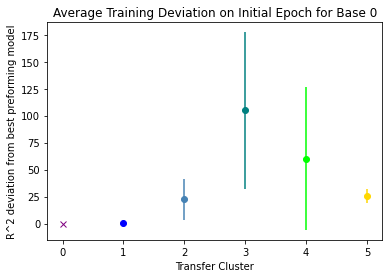

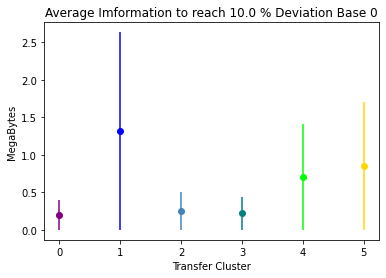

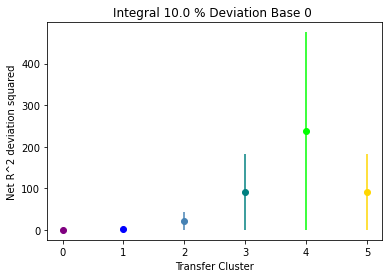

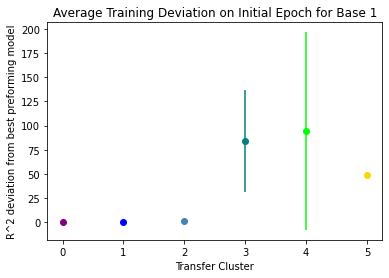

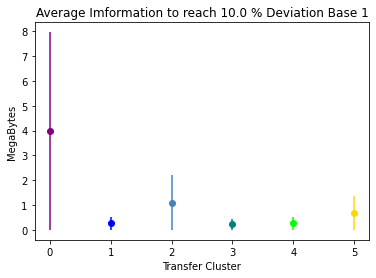

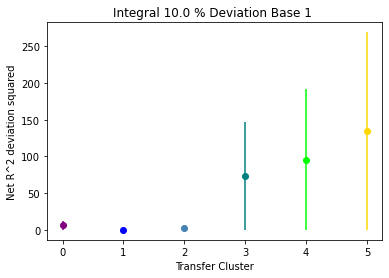

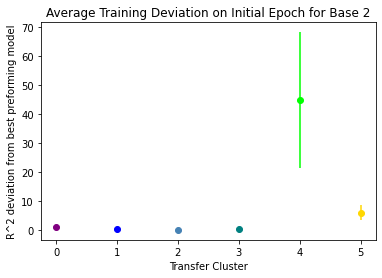

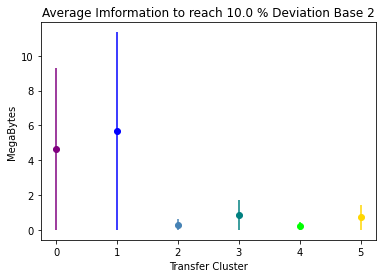

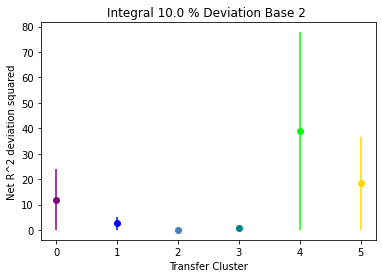

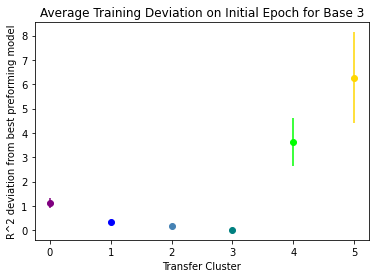

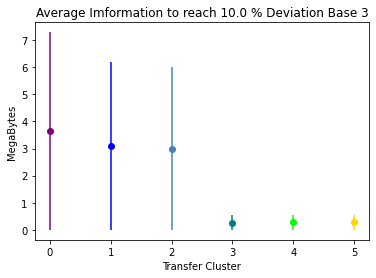

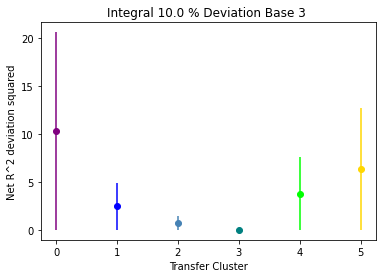

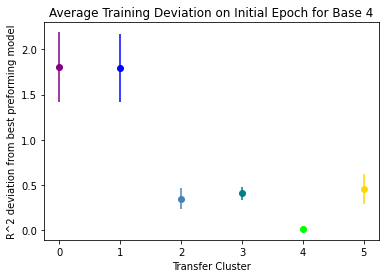

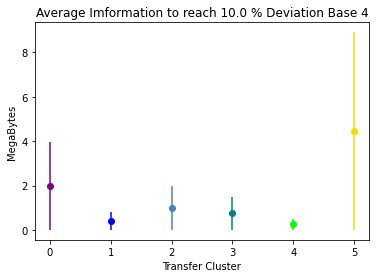

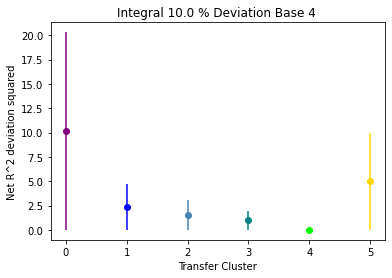

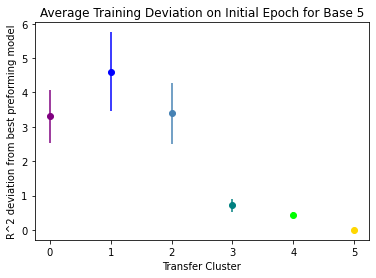

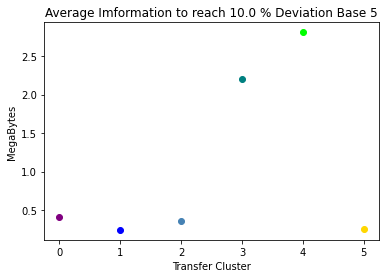

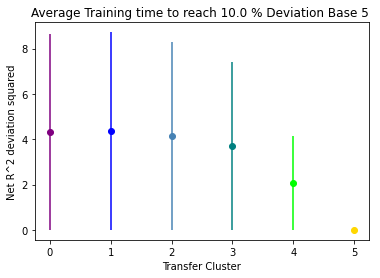

In [13]:
dif_holder=[]
std_diff=[]
overfit_holder=[]
residual_holder=[]
std_res=[]
integral_holder=[]
std_int=[]
last=0
difference=.1
GB=True
for i in dic2:
    f_index=i[0]
    #integral and residual 
    z=np.polynomial.polynomial.Polynomial(1)
    z=z.fit(range(len(dic2[i][0])), ((max(dic2[i][0]))-dic2[i][0]),20)
    n=1000
    x=np.linspace(0,resolution,n)
    y=(z.linspace(n,[0,50])[1])
    index=np.where(y<(y[0]*difference))
    ### overfit
    z=np.polynomial.polynomial.Polynomial(1)
    z=z.fit(range(len(dic2[i][0])), ((max(dic2[i][0]))-dic2[i][0]),20)
    n=1000
    x=np.linspace(0,resolution,n)
    y=(z.linspace(n,[0,50])[1])
    index=np.where(y<(y[0]*difference))
    #std_test
    sz=np.polynomial.polynomial.Polynomial(1)
    sz=sz.fit(range(len(dic2[i][0])),((max((dic2[i][0]+std_store[i])))-(dic2[i][0]+std_store[i])),20)
    sn=1000
    sx=np.linspace(0,resolution,n)
    sy=(z.linspace(n,[0,50])[1])
    sindex=np.where(y<(y[0]*difference))
    #regular diffs
    diff=max(dic2[i][0])-min(dic2[i][0])
    std1=std_store[i][0]
    #overfit test
    overfit=(dic2[i][0][0]-dic2[i][0][-1]) > 0
    if f_index is not last:
        for count,z in enumerate(dif_holder):
            if overfit_holder[count]:
                plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
            else:
                plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
        plt.title(f"Average Training Deviation on Initial Epoch for Base {i[0]-1}")
        plt.ylabel("R^2 deviation from best preforming model")
        plt.xlabel("Transfer Cluster")
        plt.show()
        for count,f in enumerate(residual_holder):
            conversion=epoch_conversions[count]
            f=f*epoch_conversions[count]
            plt.ylabel("Datapoints")
            if GB:
                conversion=conversion*byte*0.000001
                f=f*byte*0.000001 #mega bytes
                plt.ylabel("MegaBytes")
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
        plt.title(f"Average Imformation to reach {difference*100} % Deviation Base {i[0]-1}")
        plt.xlabel("Transfer Cluster")
        plt.show()
        for count,f in enumerate(integral_holder):
            plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
        plt.title(f"Integral {difference*100} % Deviation Base {i[0]-1} ")
        plt.ylabel("Net R^2 deviation squared")
        plt.xlabel("Transfer Cluster")
        plt.show()
        dif_holder=[]
        std_diff=[]
        overfit_holder=[]
        residual_holder=[]
        std_res=[]
        integral_holder=[]
        std_int=[]
    dif_holder.append(diff)
    std_diff.append(std1)
    overfit_holder.append(overfit)
    try:
        first=index[0][0]
        sfirst=index[0][0]
        integral_holder.append(sum(x[1]*y[:first]))
        std_int.append(sum(sx[1]*sy[:sfirst]))
        residual_holder.append(x[first])
        std_res.append(sx[sfirst])
    except:
        print("error", i)
    last=f_index
for count,z in enumerate(dif_holder):
    if overfit_holder[count]:
        plt.errorbar(count,-z,marker="x",c=Cluster_colors[count],yerr=std_diff[count])
    else:
        plt.errorbar(count,z,marker="o",c=Cluster_colors[count],yerr=std_diff[count])
plt.title(f"Average Training Deviation on Initial Epoch for Base {5}")
plt.ylabel("R^2 deviation from best preforming model")
plt.xlabel("Transfer Cluster")
plt.show()
for count,i in enumerate(residual_holder):
    coversion=epoch_conversions[count]
    i=i*epoch_conversions[count]
    plt.ylabel("Datapoints")
    if GB:
        conversion=conversion*byte*0.000001
        i=i*byte*0.000001 #mega bytes
        plt.ylabel("MegaBytes")
    plt.errorbar(count,i,c=Cluster_colors[count],yerr=std_res[count]*conversion,fmt="o")
plt.title(f"Average Imformation to reach {difference*100} % Deviation Base {5}")
plt.xlabel("Transfer Cluster")
plt.show()
for count,f in enumerate(integral_holder):
    plt.errorbar(count,f,c=Cluster_colors[count],yerr=std_int[count],fmt="o")
plt.title(f"Average Training time to reach {difference*100} % Deviation Base {5} ")
plt.ylabel("Net R^2 deviation squared")
plt.xlabel("Transfer Cluster")
plt.show()

In [14]:
epoch_conversions=[]
byte=df_train.iloc[0].memory_usage()
for i in M_Cluster:
    epoch_conversions.append(len(i))

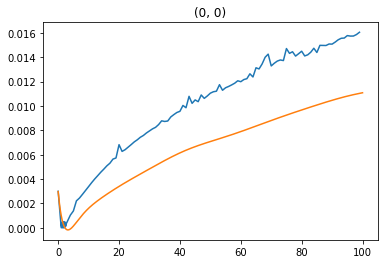

(0, 0) 1.7017017017017018
0.013018395166472678


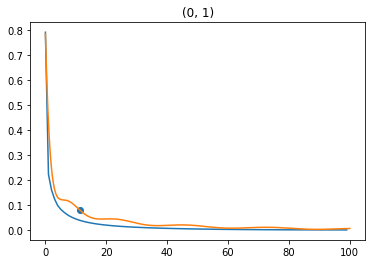

(0, 1) 11.411411411411413
77.25470980822595


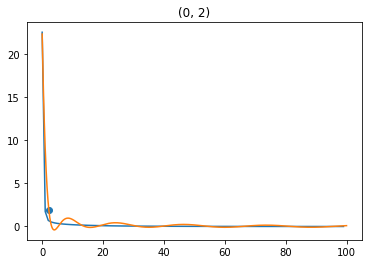

(0, 2) 2.2022022022022023
146.09724782104152


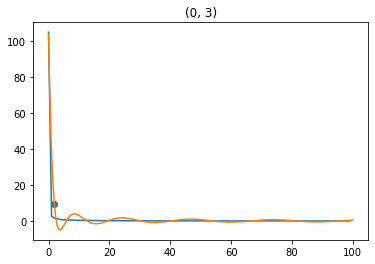

(0, 3) 1.9019019019019021
539.2372922019075


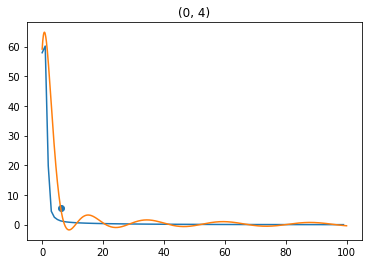

(0, 4) 6.106106106106107
4987.767808966002


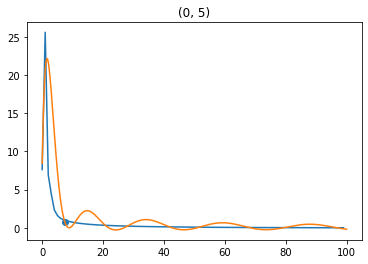

(0, 5) 7.407407407407407
2355.921315256176


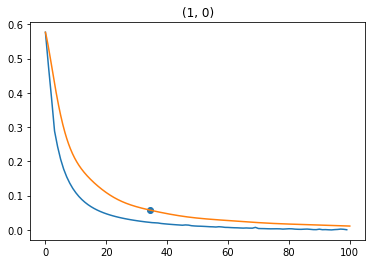

(1, 0) 34.434434434434436
658.5661474742533


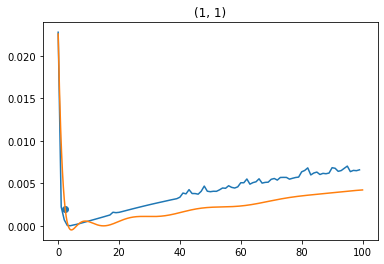

(1, 1) 2.3023023023023024
0.1641126347244651


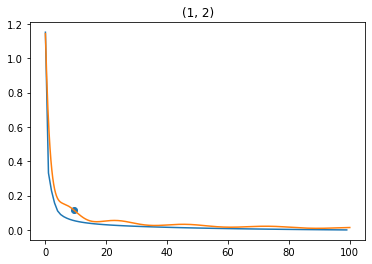

(1, 2) 9.50950950950951
77.43928688401756


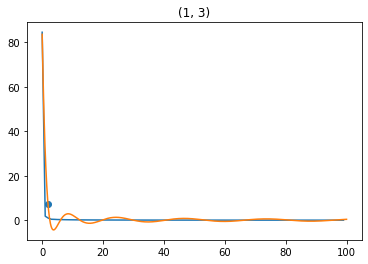

(1, 3) 1.9019019019019021
431.69494348069804


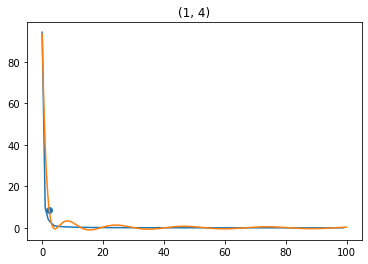

(1, 4) 2.3023023023023024
679.4152440962802


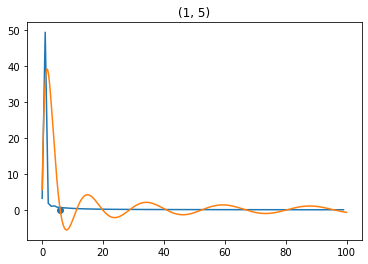

(1, 5) 5.9059059059059065
3052.7430851911045


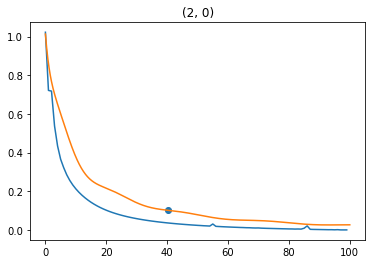

(2, 0) 40.34034034034034
1512.8220065458052


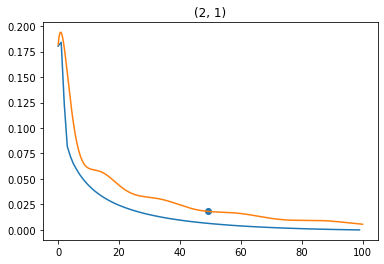

(2, 1) 49.14914914914915
397.8474384206227


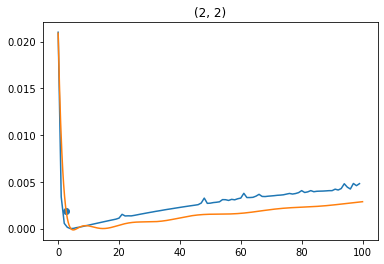

(2, 2) 2.6026026026026026
0.19128325466884422


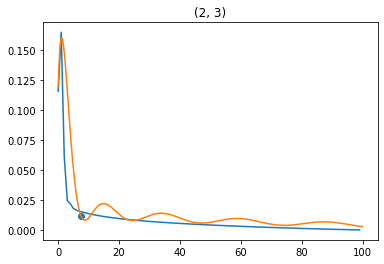

(2, 3) 7.507507507507508
16.697994156344038


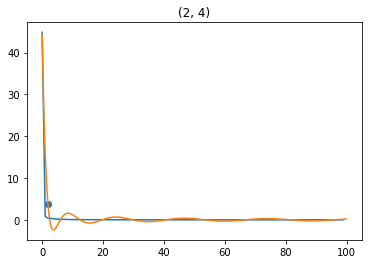

(2, 4) 1.9019019019019021
226.6867192822857


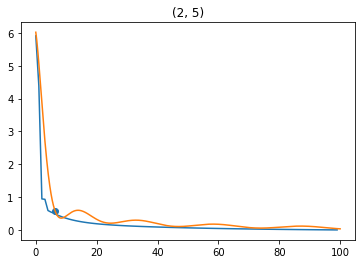

(2, 5) 6.306306306306307
370.94305296022577


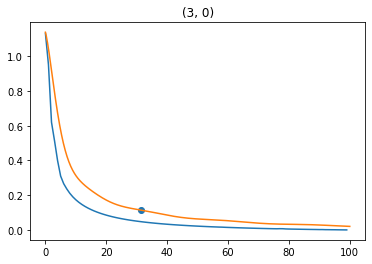

(3, 0) 31.531531531531535
978.6562427891306


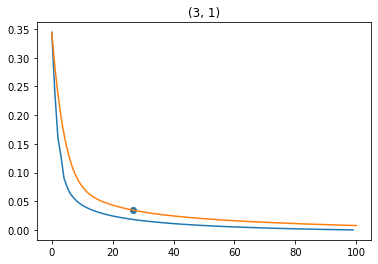

(3, 1) 26.726726726726728
201.09420585898545


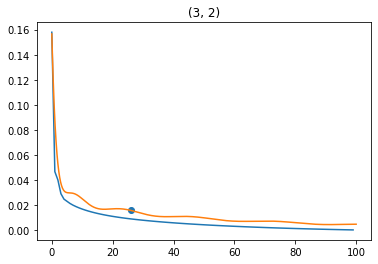

(3, 2) 25.925925925925927
65.05927021912926


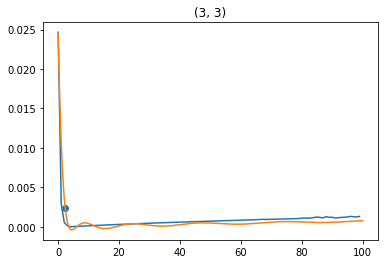

(3, 3) 2.3023023023023024
0.1840546991889943


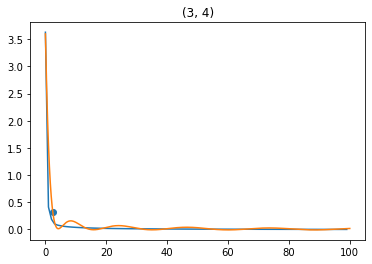

(3, 4) 2.4024024024024024
27.894033980401183


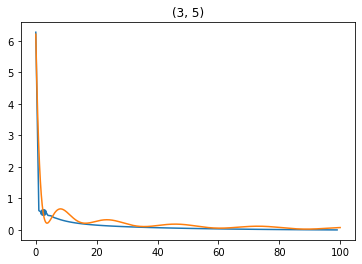

(3, 5) 2.4024024024024024
46.104085471129196


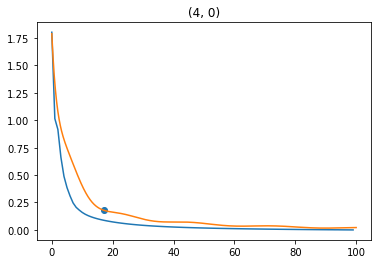

(4, 0) 17.117117117117118
559.849458881174


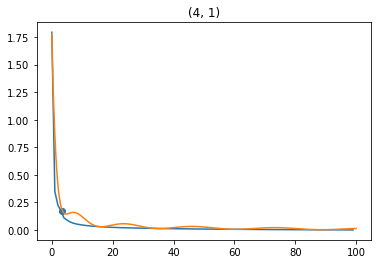

(4, 1) 3.5035035035035036
24.472062061866346


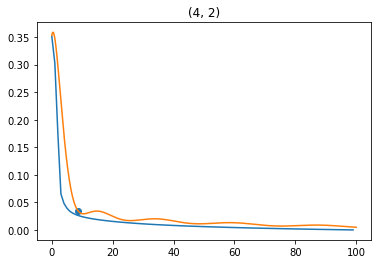

(4, 2) 8.608608608608609
41.91637163829069


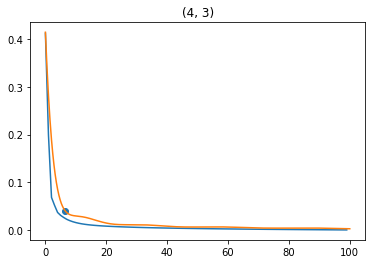

(4, 3) 6.406406406406407
19.393031955381332


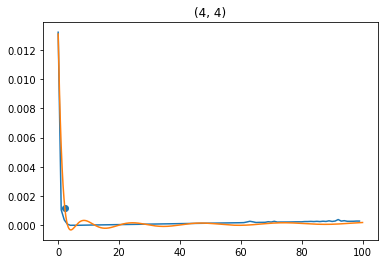

(4, 4) 2.2022022022022023
0.08733337747408695


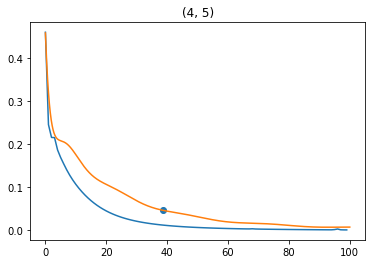

(4, 5) 38.53853853853854
669.9917114723677


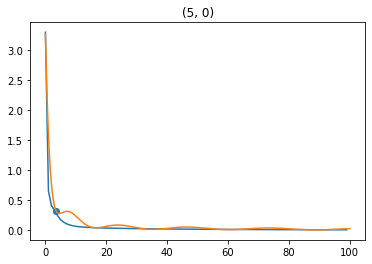

(5, 0) 3.5035035035035036
44.73652550006046


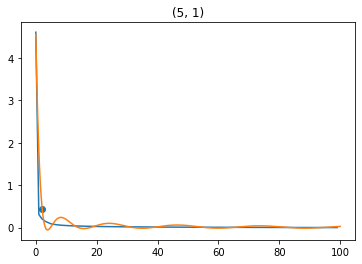

(5, 1) 2.1021021021021022
28.37522001317085


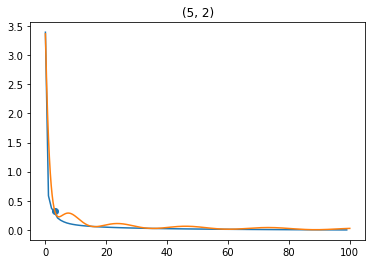

(5, 2) 3.1031031031031033
38.45945522566256


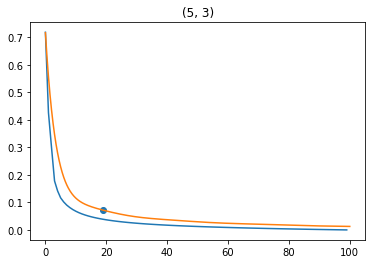

(5, 3) 19.01901901901902
212.1032706521183


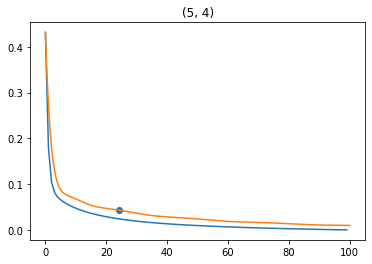

(5, 4) 24.324324324324326
168.25341044294123


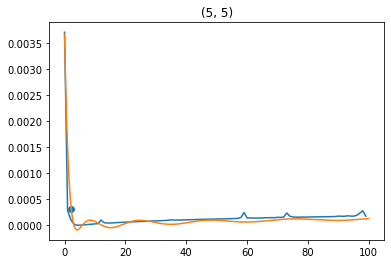

(5, 5) 2.2022022022022023
0.02435914212168499


In [15]:
for i in dic2:
    plt.plot((max(dic2[i][0]))-dic2[i][0])
    z=np.polynomial.polynomial.Polynomial(20)
    z=z.fit(range(len(dic2[i][0])), ((max(dic2[i][0]))-dic2[i][0]),20)
    n=1000
    x=np.linspace(0,resolution,n)
    y=(z.linspace(n,[0,50])[1])
    index=np.where(y<(y[0]*.1))
    f=z.integ()
    try:
        first=index[0][0]
        plt.plot(x,y)
        plt.scatter(x[first],y[first])
        plt.title(i)
        plt.show()

        print(i,x[first])
        print(sum(x[:first]*y[:first]))
    except:
        print("error", i)

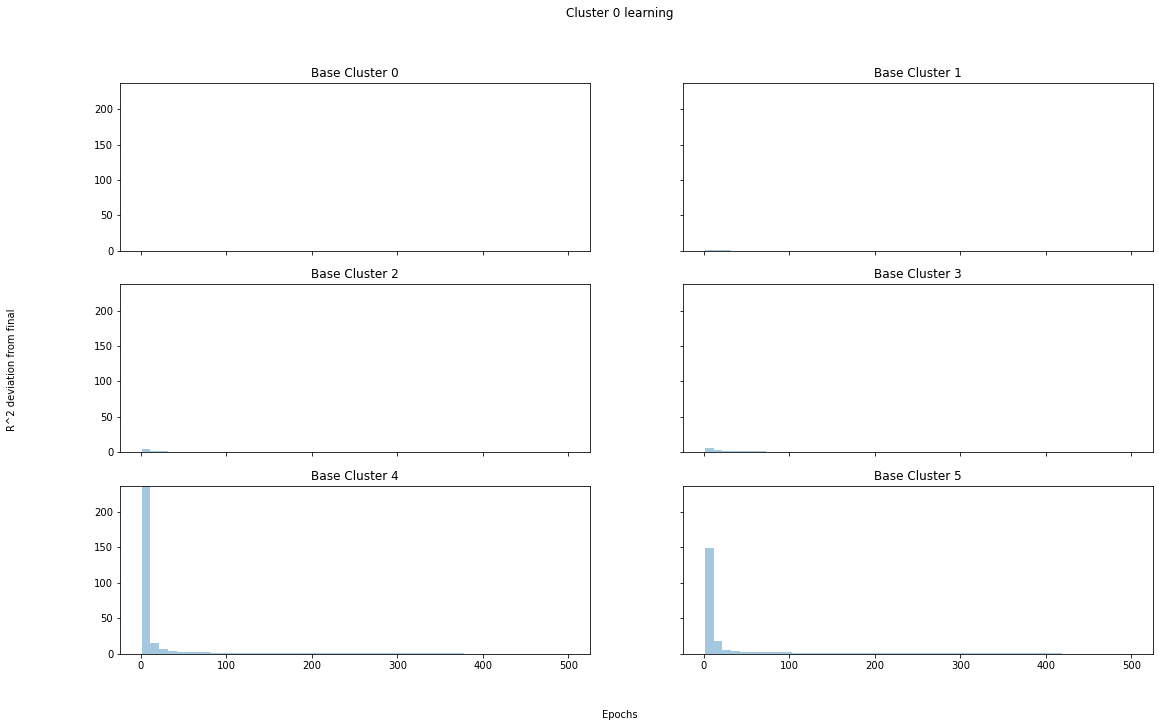

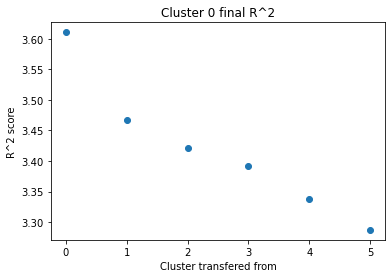

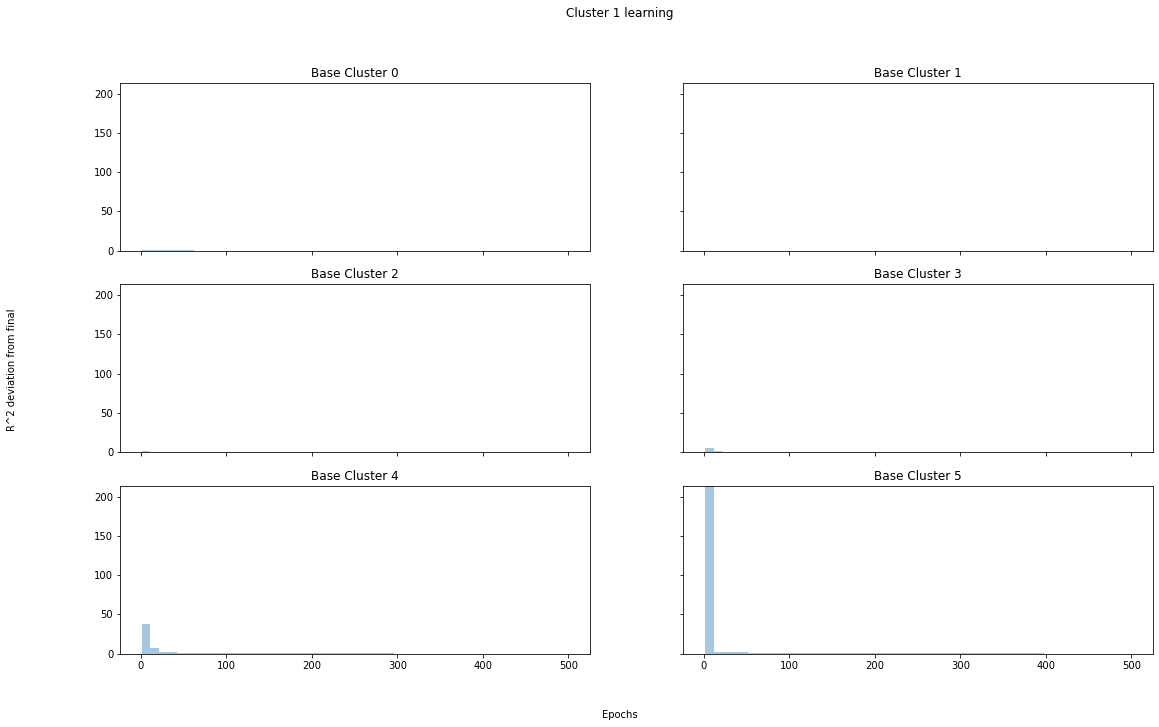

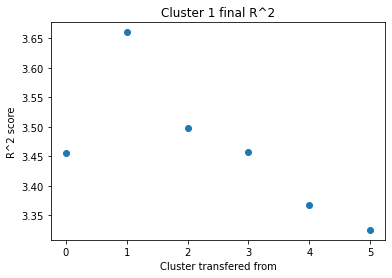

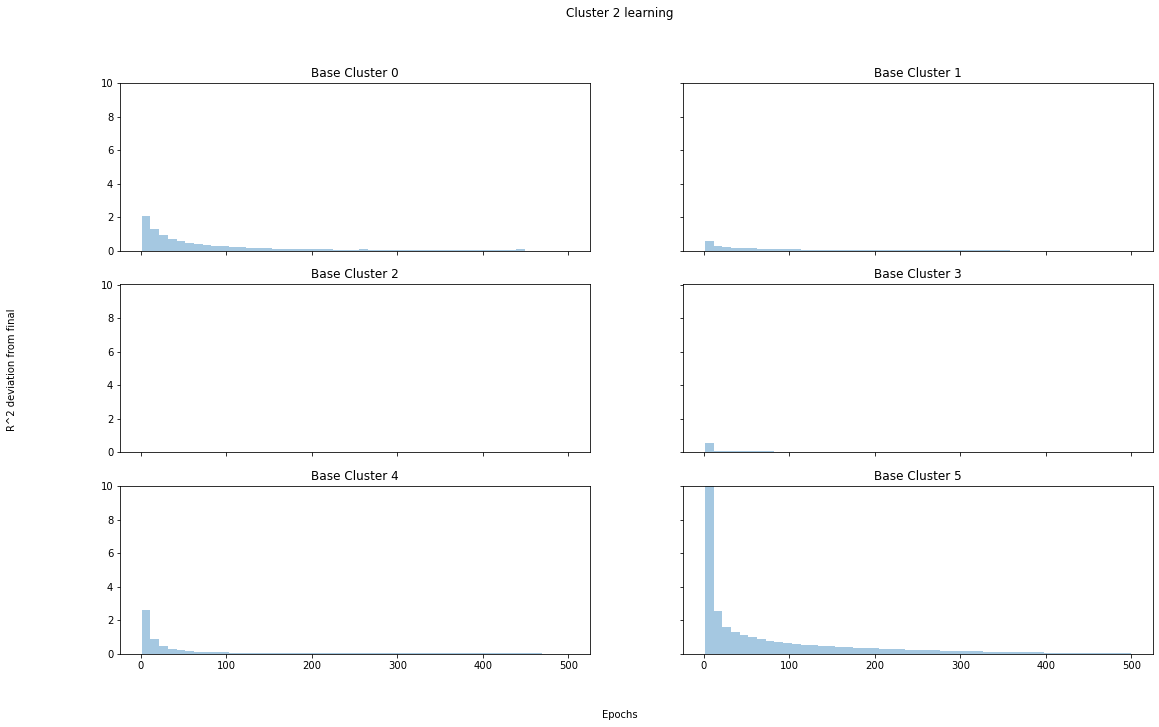

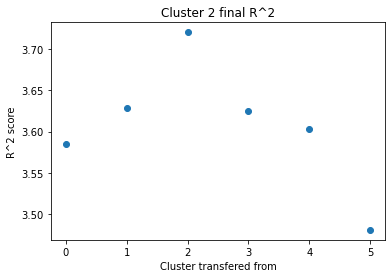

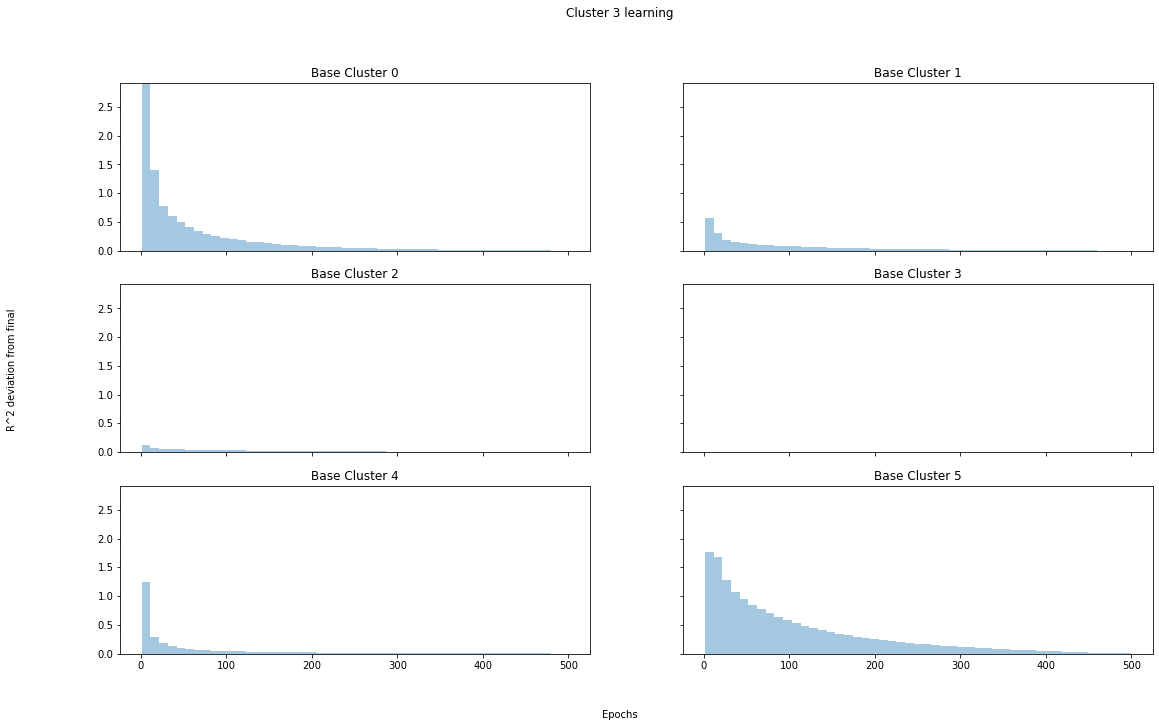

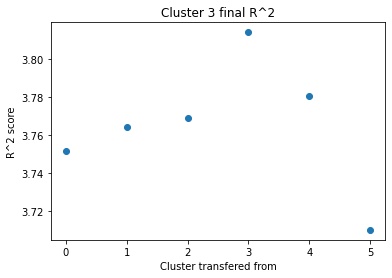

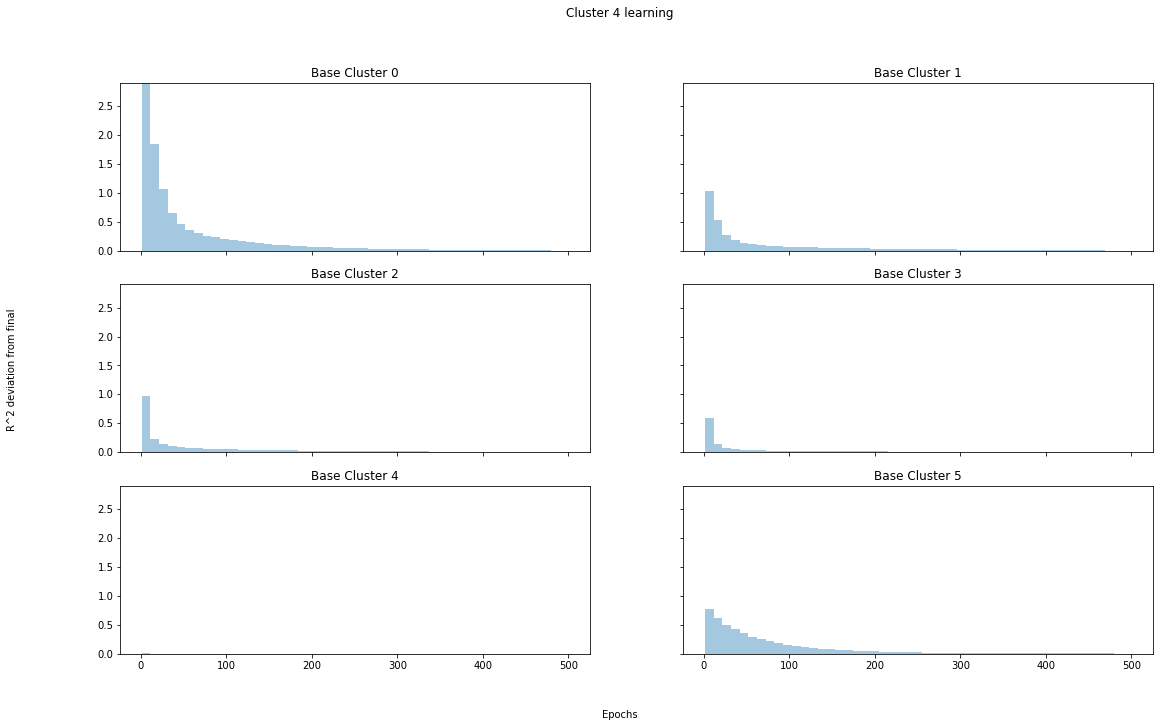

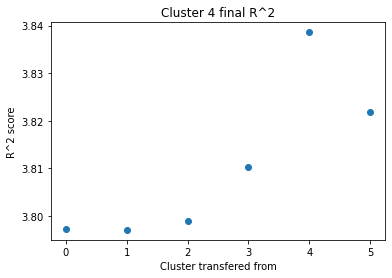

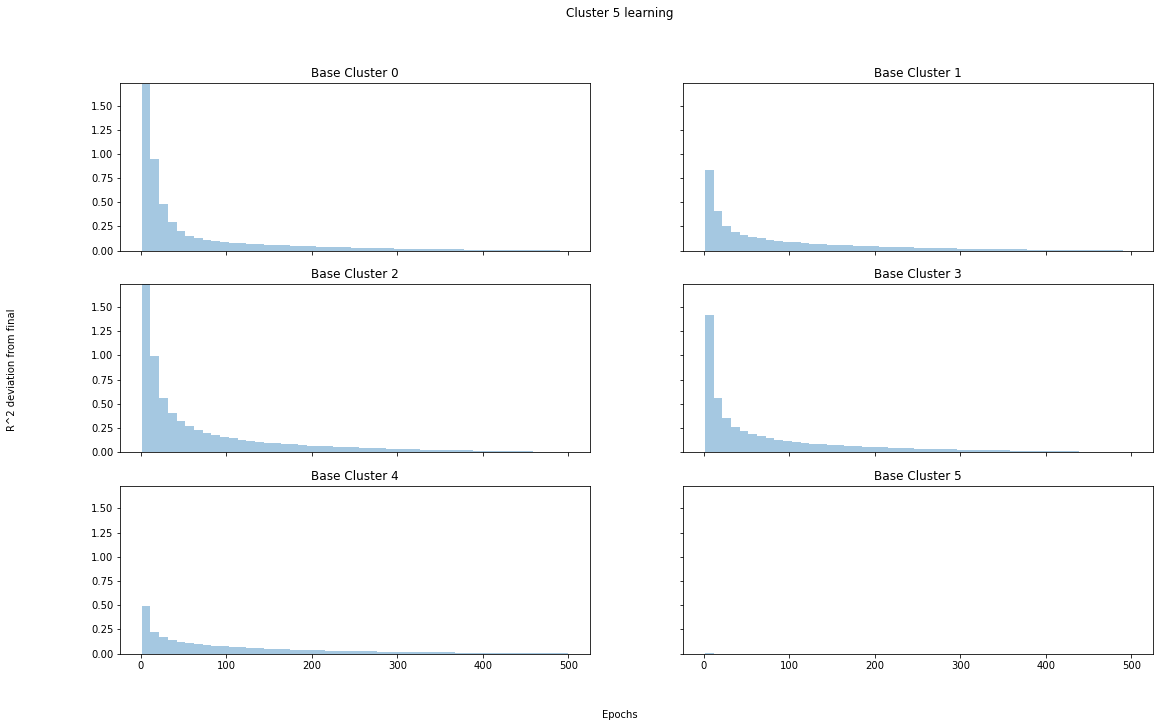

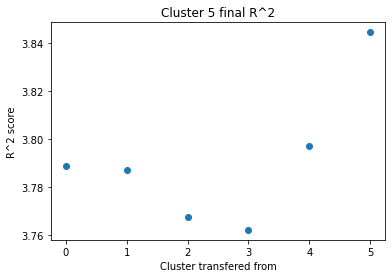

In [14]:
anaylsis(base,adjust=20)

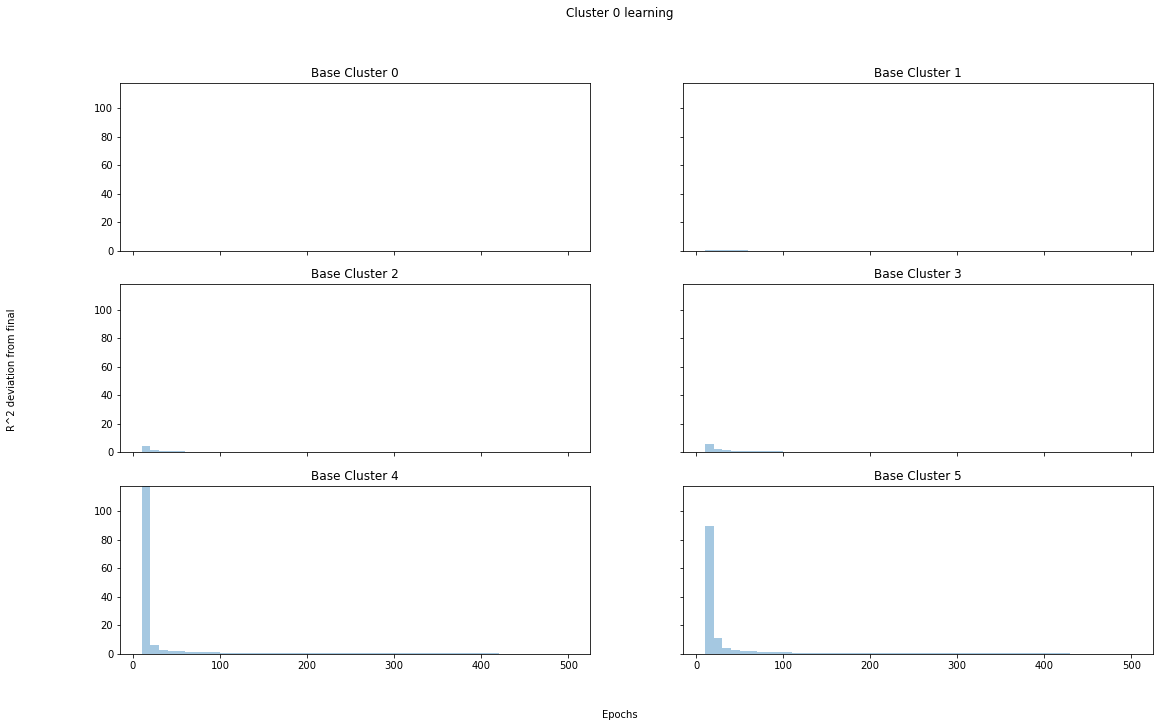

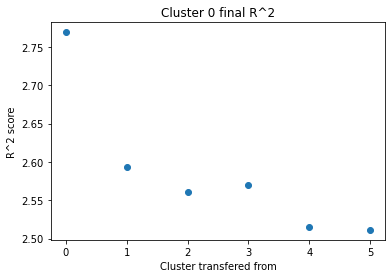

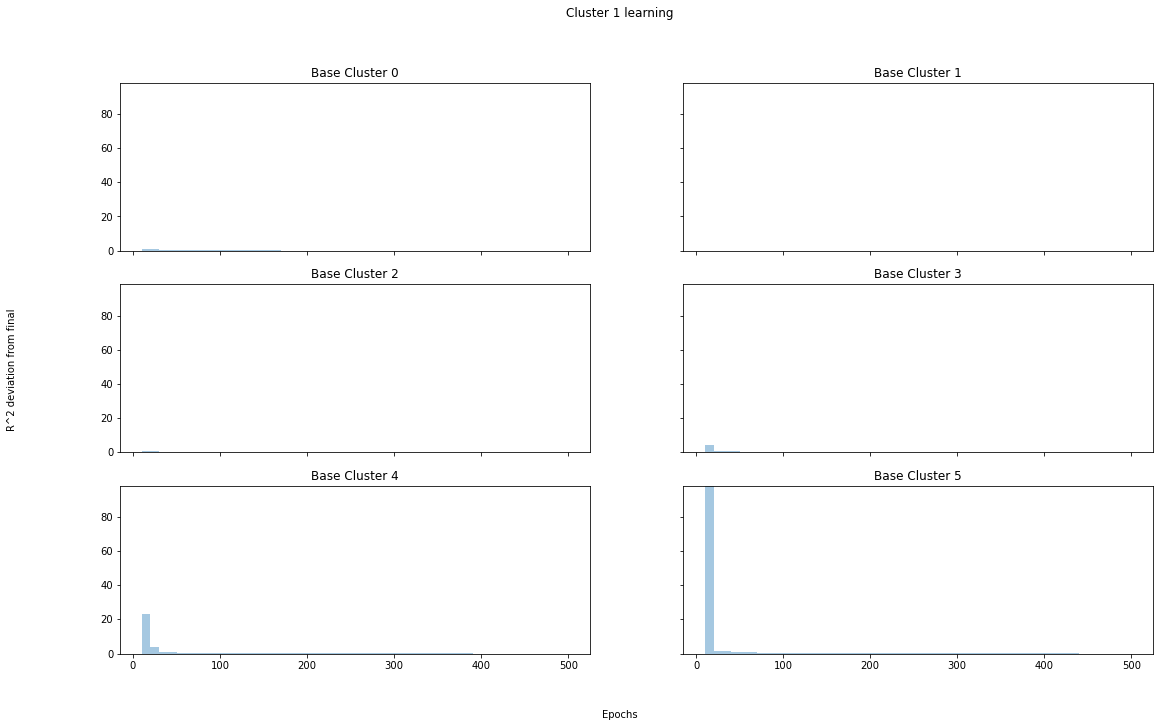

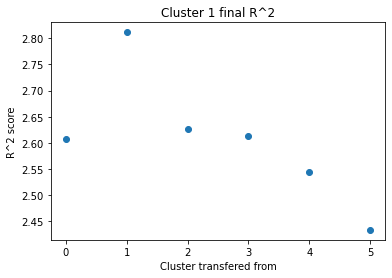

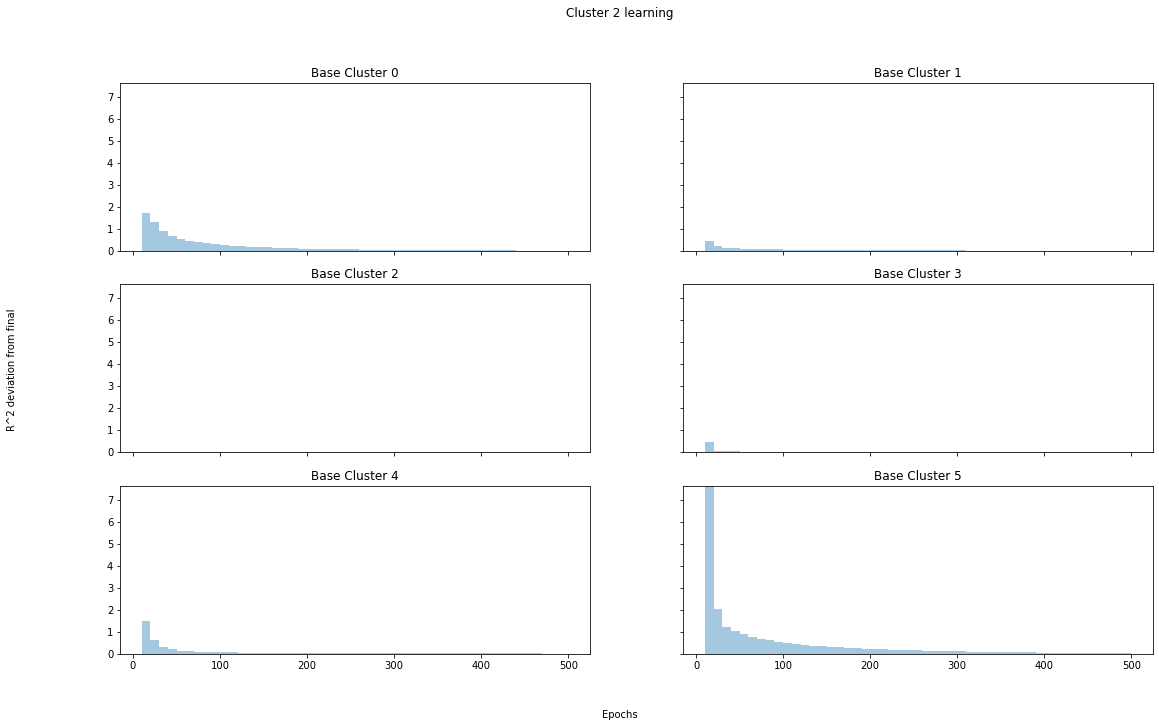

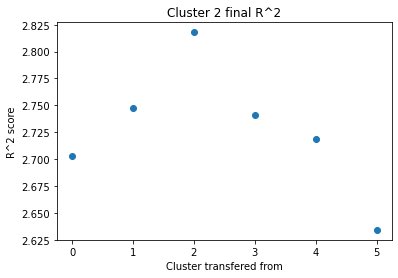

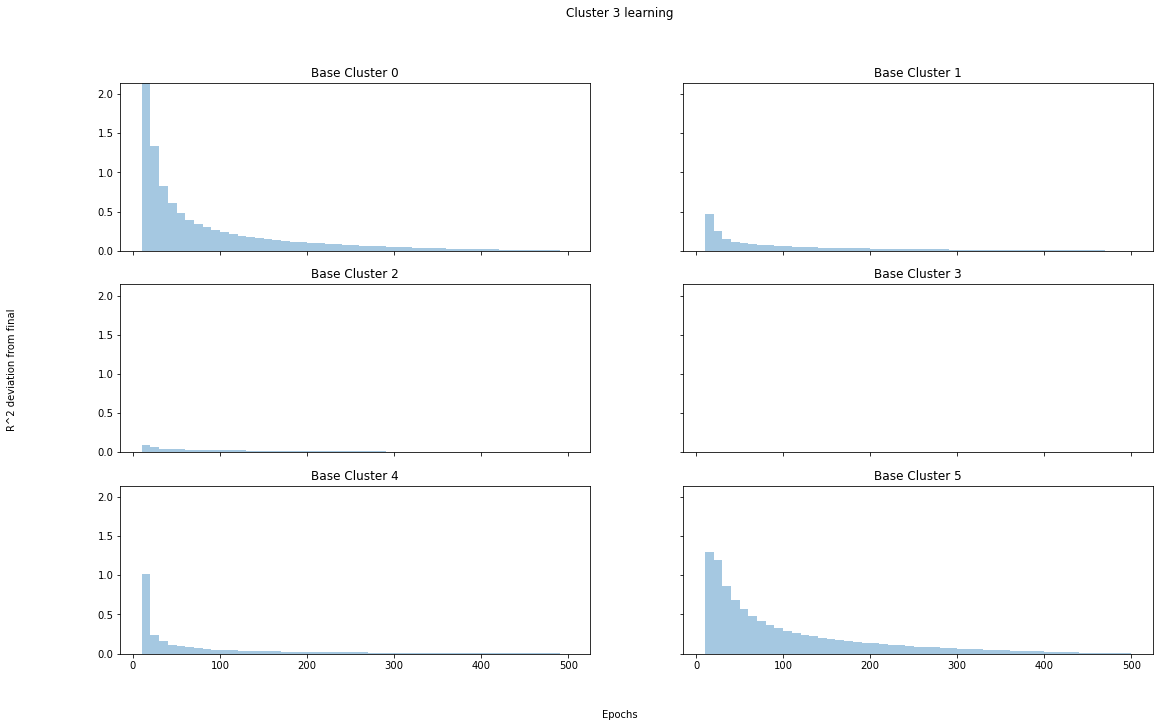

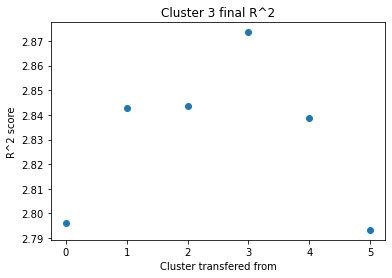

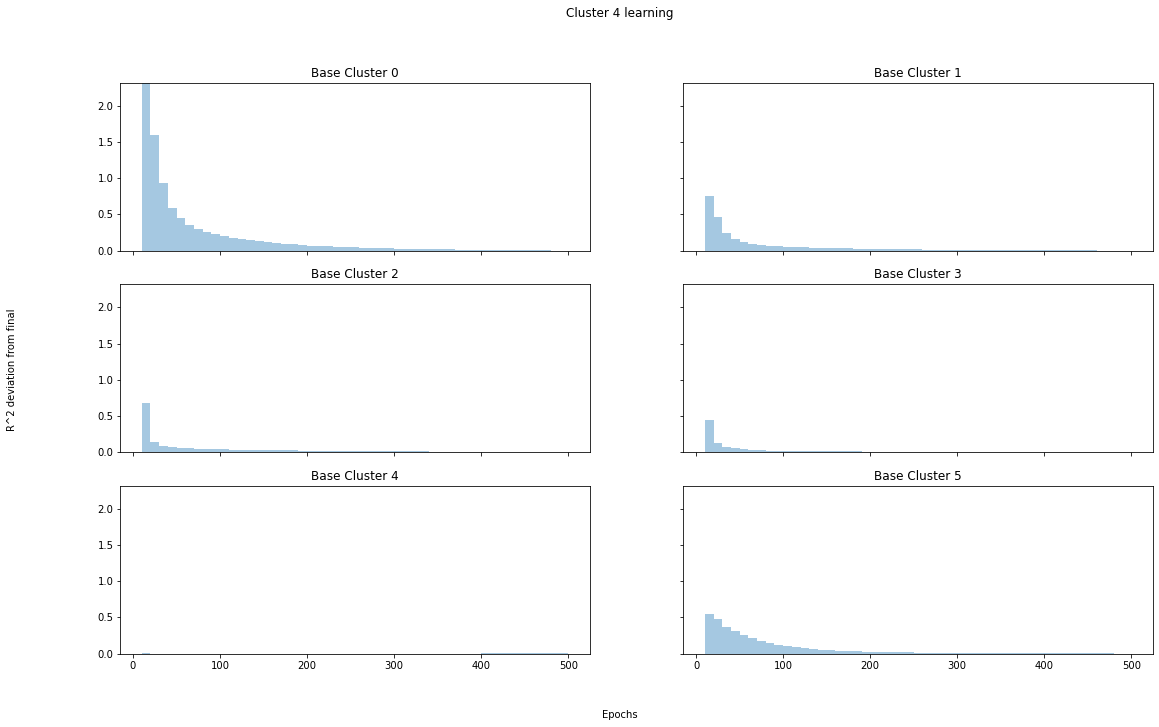

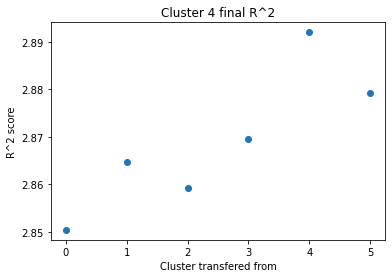

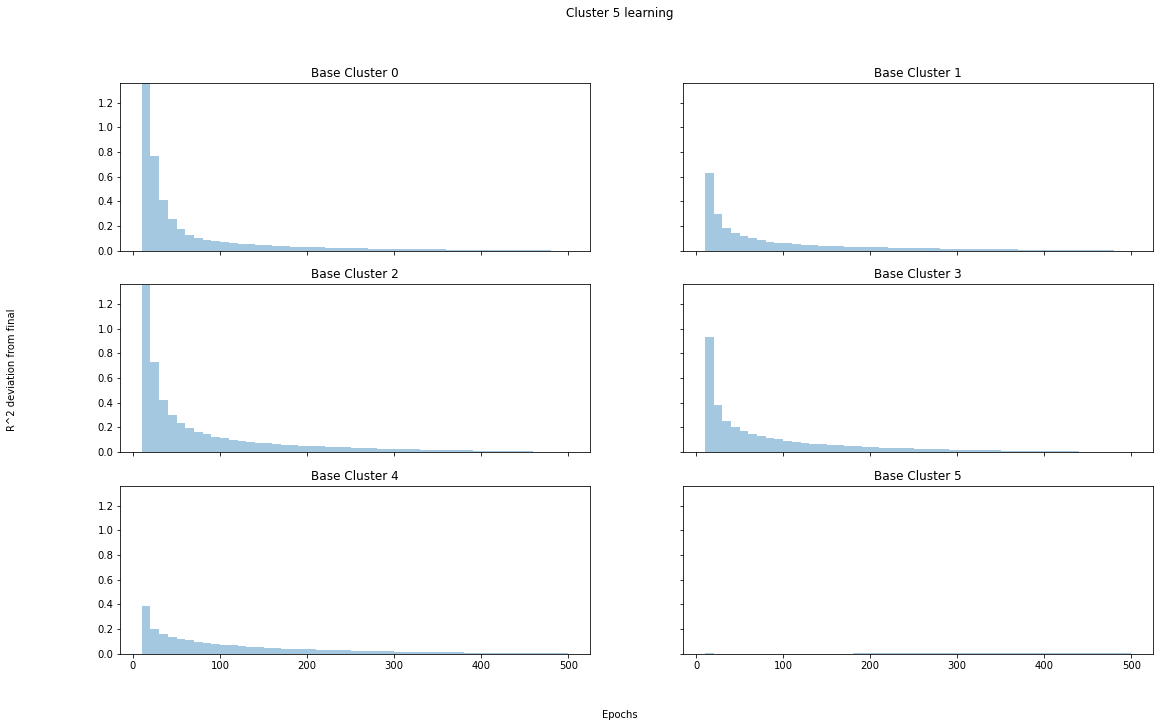

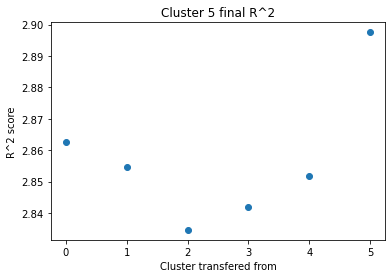

In [27]:
import numpy as np
meta=store
base={}
std={}
for count,i in enumerate((meta[0])):
    i=meta[0][i]
    base[count]=(i)
for i in meta[1:]:
    for g in i:
        for count,z in enumerate(i[g]):
            base[g][count]=np.array(base[g][count])+np.array(z)
mega=base
adjust=20
for count,i in enumerate(mega):
    hold=[]
    for g in mega[i]:
        scatter_holder=[]
        hold.append(np.array(g))
    fig, axs = plt.subplots(int(len(hold)/2),2, sharex=True,sharey=True)
    rotate=0
    base=0
    m_set=0
    min_set=0
    for z in range(len(hold)):
        scatter_holder.append(max(hold[z]))
        if m_set <= max(-(hold[z]-max(hold[z]))):
            m_set=max(-(hold[z]-max(hold[z])))
        if min_set <= min(-(hold[z]-max(hold[z]))):
            min_set=min(-(hold[z]-max(hold[z])))
        axs[base,rotate].fill_between(np.linspace(n,epochs,len(hold[z])),-(hold[z]-max(hold[z]))/adjust, step="post", alpha=0.4,label=f"Base Transfer {z}")
        #axs[base,rotate].scatter(np.linspace(n,epochs,len(hold[z])),-(hold[z]-hold[z][-1]),label=f"Base Transfer {z}")
        fig.suptitle(f"Cluster {count} learning")
        axs[base,rotate].set_title(f"Base Cluster {z}")
        if rotate==1:
            base+=1
            rotate=0
        else:
            rotate+=1
    fig.set_size_inches(18.5, 10.5)
    fig.text(0.04, 0.5, "R^2 deviation from final", va='center', rotation='vertical')
    fig.text(0.5, 0.04, "Epochs", ha='center')
    plt.ylim(min_set/adjust,m_set/adjust)
    plt.show()
    plt.scatter(range(len(scatter_holder)),np.array(scatter_holder)/adjust,label=f"Base Transfer {z}")
    plt.title(f"Cluster {count} final R^2")
    plt.ylabel("R^2 score")
    plt.xlabel("Cluster transfered from")
    plt.show()